## Transfer Learning using MNIST data
To illustrate the power and concept of transfer learning, we will train a CNN on just the digits 5,6,7,8,9.  Then we will train just the last layer(s) of the network on the digits 0,1,2,3,4 and see how well the features learned on 5-9 help with classifying 0-4.

Adapted from https://github.com/fchollet/keras/blob/master/examples/mnist_transfer_cnn.py

In [93]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [94]:
from __future__ import print_function
import random, numpy as np
import keras, tensorflow as tf
import random
import matplotlib.pyplot as plt

import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [95]:
#used to help some of the timing functions
now = datetime.datetime.now

In [96]:
# set some parameters
batch_size = 128
num_classes = 5
epochs = 10

In [97]:
class_names = ['0', '1', '2', '3', '4']

In [98]:
# set some more parameters
img_rows, img_cols = 28, 28

In [99]:
## This just handles some variability in how the input data is loaded

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

In [100]:
## To simplify things, write a function to include all the training steps
## As input, function takes a model, training set, test set, and the number of classes
## Inside the model object will be the state about which layers we are freezing and which we are training
def show_history(model):
  # Get all prediction for all image test
  y_pred_probs = model.predict(x_test)
  # Get predicted class for each image
  y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Added axis=1
  # Get true class for each image
  #y_test_classes = np.argmax(y_test, axis=1)  # Removed this line as y_test is already 1D
  y_test_classes = y_test # This line is added to use y_test directly
  # Make condition to get misclassified image
  misclassified_idx = np.where(y_pred_classes != y_test_classes)[0]
  # Select a random index from misclassified images
  random_index = misclassified_idx[random.randint(0, (len(misclassified_idx) - 1))]
  # Display image
  image = x_test[random_index]
  true_class = class_names[y_test_classes[random_index]]
  predicted_class = class_names[y_pred_classes[random_index]]
  plt.imshow(image)
  plt.title(f"True Class: {true_class}\nPredicted Class: {predicted_class}")

def train_model(model, train, test, num_classes, epochs=5):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

    t = now()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])


def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

In [101]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# create two datasets: one with digits below 5 and one with 5 and above
x_train_lt5 = x_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = x_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

x_train_gte5 = x_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5
x_test_gte5 = x_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5

In [102]:
# Define the "feature" layers.  These are the early layers that we expect will "transfer"
# to a new problem.  We will freeze these layers during the fine-tuning process

feature_layers = [
    Conv2D(16, kernel_size=(3, 3),
           padding='valid',
           input_shape=input_shape, activation='relu'),
    Conv2D(16, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten()
]

In [103]:
# Define the "classification" layers.  These are the later layers that predict the specific classes from the features
# learned by the feature layers.  This is the part of the model that needs to be re-trained for a new problem

classification_layers = [
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
]

In [104]:
# We create our model by combining the two sets of layers as follows
model = Sequential(feature_layers + classification_layers)

In [105]:
# Let's take a look
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,165 (1.14 MB)

 Trainable params: 298,165 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Now, let's train our model on the digits 5,6,7,8,9
set_seed(1234)

train_model(model,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes, epochs=epochs)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.3834 - loss: 1.4341 - val_accuracy: 0.9085 - val_loss: 0.3372
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.8406 - loss: 0.4594 - val_accuracy: 0.9333 - val_loss: 0.2171
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.8882 - loss: 0.3353 - val_accuracy: 0.9440 - val_loss: 0.1792
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - accuracy: 0.9061 - loss: 0.2856 - val_accuracy: 0.9525 - val_loss: 0.1569
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.9196 - loss: 0.2513 - val_accuracy: 0.9582 - val_loss: 0.1413
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.9243 - loss: 0.2341 - val_accuracy: 0.9611 - val_loss: 0.1289
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.9353 - loss: 0.2041 - val_accuracy: 0.9640 - val_loss: 0.1180
Epoch 8/10
230/230

### Freezing Layers
Keras allows layers to be "frozen" during the training process.  That is, some layers would have their weights updated during the training process, while others would not.  This is a core part of transfer learning, the ability to train just the last one or several layers.

Note also, that a lot of the training time is spent "back-propagating" the gradients back to the first layer.  Therefore, if we only need to compute the gradients back a small number of layers, the training time is much quicker per iteration.  This is in addition to the savings gained by being able to train on a smaller data set.

### Looking Inside Model

## [Code for Viewing Layers](https://docs.google.com/document/d/1iACjBPWTWvXTSecBNHx1xEtODcHSpnU6HFY82b4b6Ys)

#### Copy and Paste the code here!

In [107]:
!pip install pydot graphviz

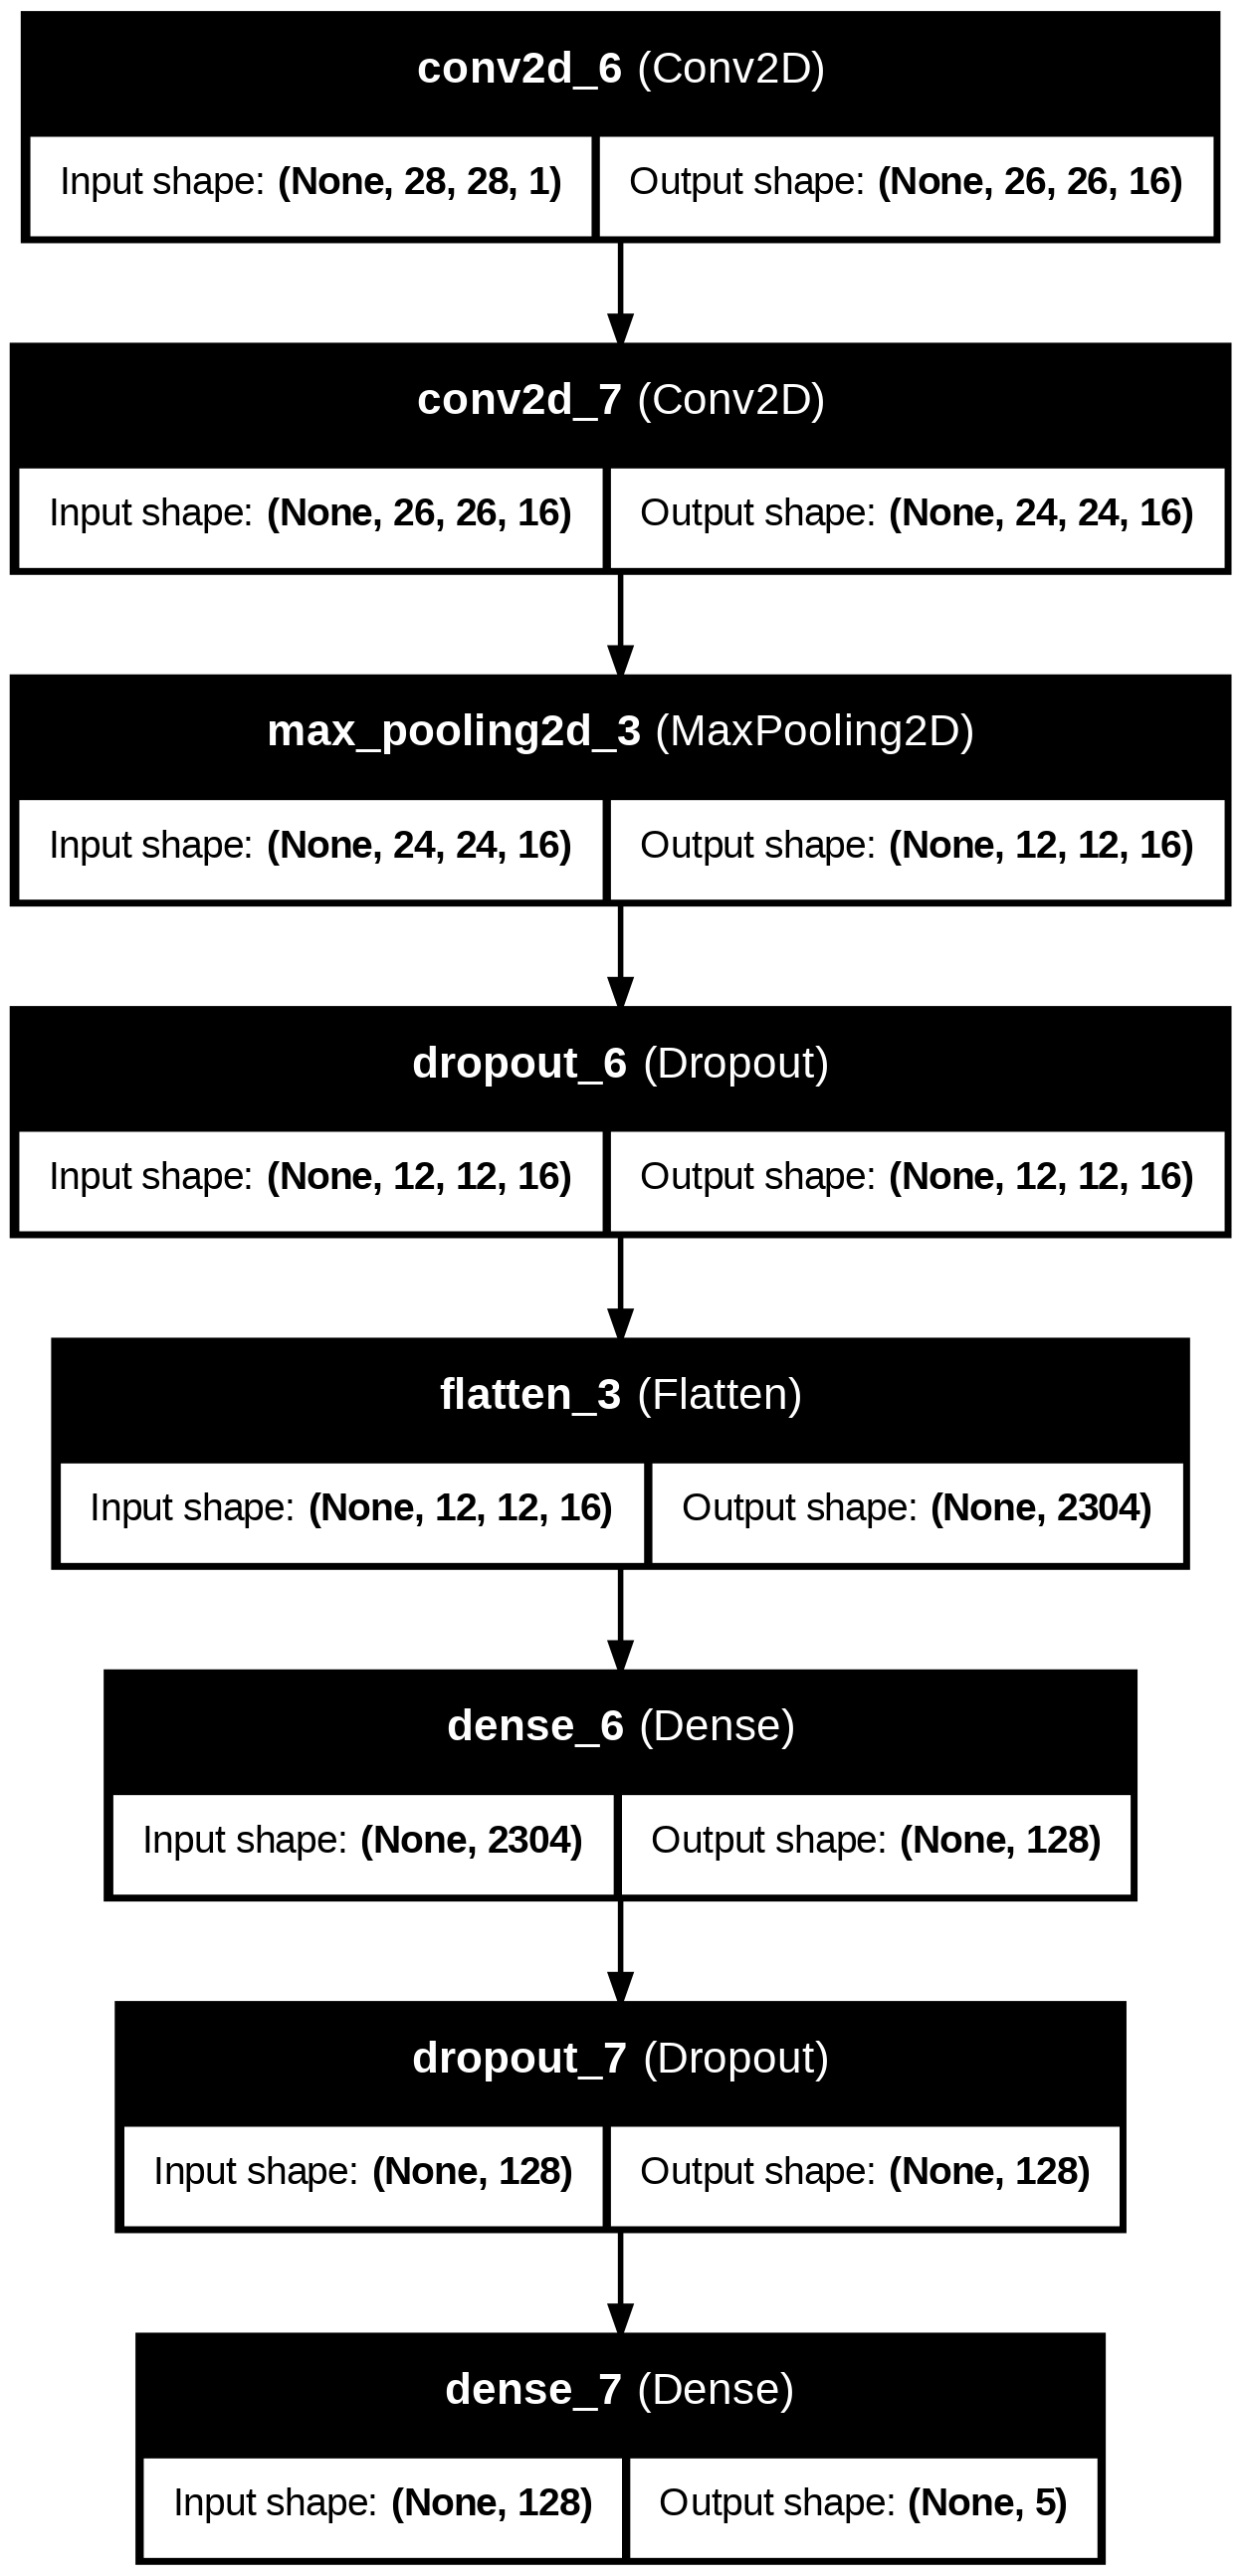

In [108]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [109]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,167 (1.14 MB)

 Trainable params: 298,165 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Freeze CNN Layers (Low-level or Early Layers)

In [110]:
# Freeze only the
for l in feature_layers:
    l.trainable = False

Observe below the differences between the number of *total params*, *trainable params*, and *non-trainable params*.

In [111]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,167 (1.14 MB)

 Trainable params: 295,685 (1.13 MB)

 Non-trainable params: 2,480 (9.69 KB)

 Optimizer params: 2 (12.00 B)

In [112]:
train_model(model,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes, epochs=epochs//4)

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Epoch 1/2
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.7551 - loss: 0.7864 - val_accuracy: 0.9646 - val_loss: 0.1270
Epoch 2/2
240/240 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.9275 - loss: 0.2331 - val_accuracy: 0.9735 - val_loss: 0.0903
Training time: 0:00:32.294828
Test score: 0.0902651846408844
Test accuracy: 0.9735357165336609


Note that after a single epoch, we are already achieving results on classifying 0-4 that are comparable to those achieved on 5-9 after 5 full epochs.  This despite the fact the we are only "fine-tuning" the last layer of the network, and all the early layers have never seen what the digits 0-4 look like.

Also, note that even though nearly all (590K/600K) of the *parameters* were trainable, the training time per epoch was still much reduced.  This is because the unfrozen part of the network was very shallow, making backpropagation faster.

## Exercise
### To do:
- Now write code to reverse this training process.  That is, you will train on the digits 0-4, and then finetune only the last layers on the digits 5-9.

In [113]:
model_2 = Sequential(feature_layers + classification_layers)

In [114]:
# Unfreeze only the
for l in feature_layers:
    l.trainable = True

In [115]:
model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,165 (1.14 MB)

 Trainable params: 298,165 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
set_seed(1234)

train_model(model_2,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes, epochs=epochs)

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.9393 - loss: 0.1902 - val_accuracy: 0.9784 - val_loss: 0.0733
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9486 - loss: 0.1625 - val_accuracy: 0.9802 - val_loss: 0.0650
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.9556 - loss: 0.1463 - val_accuracy: 0.9815 - val_loss: 0.0573
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.9605 - loss: 0.1262 - val_accuracy: 0.9837 - val_loss: 0.0529
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - accuracy: 0.9620 - loss: 0.1238 - val_accuracy: 0.9840 - val_loss: 0.0484
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9642 - loss: 0.1170 - val_accuracy: 0.9864 - val_loss: 0.0457
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9684 - loss: 0.1066 - val_accuracy: 0.9875 - val_loss: 0.0431
Epoch 8/10
240/2

In [117]:
model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,167 (1.14 MB)

 Trainable params: 298,165 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [118]:
for l in feature_layers:
    l.trainable = False

In [119]:
model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,167 (1.14 MB)

 Trainable params: 295,685 (1.13 MB)

 Non-trainable params: 2,480 (9.69 KB)

 Optimizer params: 2 (12.00 B)

In [120]:
train_model(model_2,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes, epochs=epochs//4)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Epoch 1/2
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8144 - loss: 0.5767 - val_accuracy: 0.9601 - val_loss: 0.1257
Epoch 2/2
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9281 - loss: 0.2243 - val_accuracy: 0.9673 - val_loss: 0.1032
Training time: 0:00:18.647927
Test score: 0.10322729498147964
Test accuracy: 0.9672906994819641


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


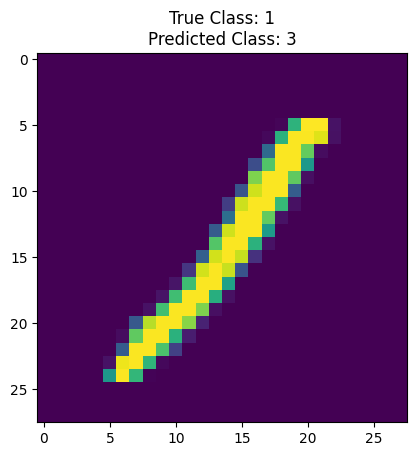

In [121]:
show_history(model_2)